In [1]:
import numpy as np
import pandas as pd
from google.colab import drive

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
drive.mount('/content/drive')
df_prods = pd.read_csv("drive/MyDrive/products.csv", on_bad_lines='skip')
df_prods.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text;;;;;;;;;;;;;;;;;;;;;;;;
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,"2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,13469...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"3,B000LQOCH0,ABXLMWJIXXAIN,""Natalia Corres """"N...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,"5,B006K2ZZ7K,A1UQRSCLF8GW1T,""Michael D. Bigham...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Delete rows with bad "Score" field (strings values)
df_prods['Score'] = pd.to_numeric(df_prods['Score'], errors = 'coerce')
df_prods.dropna(inplace = True, subset=['Score', 'Summary', 'Text;;;;;;;;;;;;;;;;;;;;;;;;'])

#There are blank columns after Text, that is the reason of the ;
texts = df_prods["Text;;;;;;;;;;;;;;;;;;;;;;;;"]
summs = df_prods["Summary"]
df_prods["Comment"] = df_prods["Text;;;;;;;;;;;;;;;;;;;;;;;;"] + df_prods["Summary"]

d = {'Comment': df_prods["Comment"]}
comms_df = pd.DataFrame(data=d)


# 1. Preprocessing

Removal of useless characters

In [4]:
bad_chars = ["!", "\"", "\$", "%", "&", "/", "\(", "\)", "=", "_", "ˆ", "¡", "@", ";", "\*", "\+", "\.", "\?"]
for c in bad_chars:
  comms_df['Comment'] = comms_df['Comment'].replace({c:""}, regex=True)
comms_df['Comment'] = comms_df['Comment'].replace({"<br >":" "}, regex=True)

comms_df['Comment'] = comms_df['Comment'].str.lower()
print(comms_df.shape)
comms_df.head()

(9620, 1)


,Comment
0,i have bought several of the vitality canned d...
3,if you are looking for the secret ingredient i...
8,right now i'm mostly just sprouting this so my...
9,this is a very healthy dog food good for their...
16,i love eating them and they are good for watch...


Lemmatization

In [5]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

comms_df = comms_df.astype(str)

def lemmatize3_text(text):
  row = []
  for word, tag in nltk.pos_tag(w_tokenizer.tokenize(text)):
    wntag = tag[0].lower()
    wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None # We lemmatize adverbs, nouns and verbs
    if not wntag:
      lemma = word
    else:
      lemma = lemmatizer.lemmatize(word, wntag)
    row.append(lemma)
  return row 

comms_df['Comment'] = comms_df['Comment'].apply(lemmatize3_text)
comms_df['Comment'] = comms_df['Comment'].apply(lambda x : " ".join(x))

comms_df.head(100)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,Comment
0,i have buy several of the vitality can dog foo...
3,if you be look for the secret ingredient in ro...
8,right now i'm mostly just sprout this so my ca...
9,this be a very healthy dog food good for their...
16,i love eat them and they be good for watch tv ...
...,...
522,i have try a lot of sv chip and these be the b...
526,these backyard bbq kettle chip be a great deal...
529,these bag have a lot of overcooked brown piece...
534,after open numerous bag i find that none of th...


# 2. Vectorization

## 2.1 TFIDF

In [6]:
####################################################
#--------------------CONFIGS-----------------------#
# 1 TFIDF                                          #
# 2 TFIDF + N-grams                                #
# 3 TFIDF + N-grams + POS tagging                  #
# 4 TFIDF + N-grams + POS tagging + other features #
#--------------------------------------------------#
####################################################

from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sp

vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True)
config1 = vectorizer.fit_transform(comms_df['Comment'])
config1_df=pd.DataFrame.sparse.from_spmatrix(config1,columns=vectorizer.get_feature_names())
print(config1_df.shape, type(config1_df))
config1_df.head()


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(9620, 18801) <class 'pandas.core.frame.DataFrame'>


,00g,00try,01,0107,021,03510,060cup,065,075,08,...,ziwipeak,zoe,zon,zots,zotz,zucchini,zuke,zukes,zuma,zyto
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2.2 TFIDF + Ngram

In [7]:
ngram_vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, ngram_range=(1,3))
config2 = ngram_vectorizer.fit_transform(comms_df['Comment'])
config2_df=pd.DataFrame.sparse.from_spmatrix(config2,columns=ngram_vectorizer.get_feature_names())
print(config2_df.shape)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(9620, 390270)


## 2.3 TFIDF + Ngram + POS tagging

In [8]:
import copy
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

ngram_vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, ngram_range=(1,3))
comms_tokenized_df = copy.deepcopy(comms_df)
comms_tokenized_df['Comment'] = comms_tokenized_df['Comment'].str.lower().apply(nltk.word_tokenize)
comms_tokenized_df['Comment'] = comms_tokenized_df['Comment'].apply(nltk.pos_tag)
comms_tokenized_df['Comment'] = comms_tokenized_df['Comment'].apply(lambda x : ' '.join(map(str, x)))

comms_tokenized_df['Comment'] = comms_tokenized_df['Comment'].replace(", ", "", regex=True)
comms_tokenized_df['Comment'] = comms_tokenized_df['Comment'].replace("''", "0", regex=True)
comms_tokenized_df['Comment'] = comms_tokenized_df['Comment'].replace("'", "", regex=True)
comms_tokenized_df['Comment'] = comms_tokenized_df['Comment'].replace("\(", "", regex=True)
comms_tokenized_df['Comment'] = comms_tokenized_df['Comment'].replace("\)", "", regex=True)

print(comms_tokenized_df['Comment'].head())

config3 = ngram_vectorizer.fit_transform(comms_tokenized_df['Comment'])
config3_df=pd.DataFrame.sparse.from_spmatrix(config3,columns=ngram_vectorizer.get_feature_names())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


0     i0NN have0VBP buy0VBN several0JJ of0IN the0DT ...
3     if0IN you0PRP be0VB look0VBN for0IN the0DT sec...
8     right0RB now0RB i0JJ "m"VBP mostly0RB just0RB ...
9     this0DT be0VB a0DT very0RB healthy0JJ dog0NN f...
16    i0NN love0VBP eat0VB them0PRP and0CC they0PRP ...
Name: Comment, dtype: object


# 3. Feature Selection

In [9]:
from sklearn.feature_selection import SelectKBest, f_regression, chi2
best = int(len(config1_df.columns)*0.3)
k_config1 =  SelectKBest(k=best, score_func=chi2)
k_config2 =  SelectKBest(k=best, score_func=chi2)
k_config3 =  SelectKBest(k=best, score_func=chi2)

In [11]:
import copy
X_train_config1 = copy.deepcopy(config1_df)
X_train_config2 = copy.deepcopy(config2_df)
X_train_config3 = copy.deepcopy(config3_df)

# Se usa la misma y en todos los algoritmos siguientes
Y_train_config1 = copy.deepcopy(df_prods)
Y_train_config1 = Y_train_config1["Score"]
Y_train_config1 = Y_train_config1.astype({"Score" : "int"})

print(X_train_config1.shape)
print(Y_train_config1.shape)

k_config1 = k_config1.fit(X_train_config1, Y_train_config1)
X_train_config1 = k_config1.transform(X_train_config1)

k_config2 = k_config2.fit(X_train_config2, Y_train_config1)
X_train_config2 = k_config2.transform(X_train_config2)

k_config3 = k_config3.fit(X_train_config3, Y_train_config1)
X_train_config3 = k_config3.transform(X_train_config3)


Y_train_config1.value_counts()


(9620, 18801)
(9620,)


5    6807
4    1049
1     918
3     482
2     364
Name: Score, dtype: int64

## 3.1 Dealing with Imbalanced Data (DO NOT EXECUTE)

We have to deal with imbalance data (too many 5 star reviews) with a combination of oversampling and undersampling using SMOTEENN. We will resample all targets except the 5 star reviews. Unfortunately there is no enough RAM in Colab to execute this code

In [ ]:
from imblearn.combine import SMOTEENN

sample = SMOTEENN(sampling_strategy="auto") 
X, Y = sample.fit_resample(X_train_config1.to_numpy(), Y_train_config1.to_numpy())

Y_train_config1.value_counts()

5    6807
4    1049
1     918
3     482
2     364
Name: Score, dtype: int64

In [ ]:
import collections
counter = collections.Counter(Y)
counter


Counter({1: 6, 2: 6807, 4: 1, 5: 431})

# 4. Classification algorithms

## 4.1 Multinomial Naive Bayes

Fit and predict for TFIDF, TFIDF + Ngram, TFIDF + Ngram + Pos tagging

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

X_train,X_test,y_train,y_test = train_test_split(X_train_config1, Y_train_config1, test_size=0.3)

model = MultinomialNB()
param={'alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]}
clf=GridSearchCV(model,param,scoring="f1_micro",cv=10,return_train_score=True)

clf.fit(X_train, y_train)
y_model_mn = clf.predict(X_test)


X_train_2,X_test_2,y_train_2,y_test_2 = train_test_split(X_train_config2, Y_train_config1, test_size=0.3)

clf_2 = GridSearchCV(model,param,scoring="f1_micro",cv=10,return_train_score=True)
clf_2.fit(X_train_2, y_train_2)
y_model_mn_2 = clf_2.predict(X_test_2)


X_train_3,X_test_3,y_train_3,y_test_3 = train_test_split(X_train_config2, Y_train_config1, test_size=0.3)

clf_3 = GridSearchCV(model,param,scoring="f1_micro",cv=10,return_train_score=True)
clf_3.fit(X_train_3, y_train_3)
y_model_mn_3 = clf_3.predict(X_test_3)



Results

In [14]:
from sklearn.metrics import f1_score

mn_score = f1_score(y_test, y_model_mn, average='micro')
mn_score_2 = f1_score(y_test_2, y_model_mn_2, average='micro')
mn_score_3 = f1_score(y_test_3, y_model_mn_3, average='micro')

print(f"Multinomial score TFIDF: {mn_score}")
print(f"Multinomial score TFIDF + Ngram: {mn_score_2}")
print(f"Multinomial score TFIDF + Ngram + POS tagging: {mn_score_3}")

Multinomial score TFIDF: 0.7716562716562717
Multinomial score TFIDF + Ngram: 0.7505197505197505
Multinomial score TFIDF + Ngram + POS tagging: 0.7428967428967429


Confusion matrix for TFIDF

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_model_mn, labels=clf.classes_))

              precision    recall  f1-score   support

           1       0.78      0.42      0.55       294
           2       0.33      0.11      0.16       101
           3       0.49      0.18      0.26       150
           4       0.62      0.16      0.25       308
           5       0.79      0.99      0.88      2033

    accuracy                           0.77      2886
   macro avg       0.60      0.37      0.42      2886
weighted avg       0.74      0.77      0.72      2886



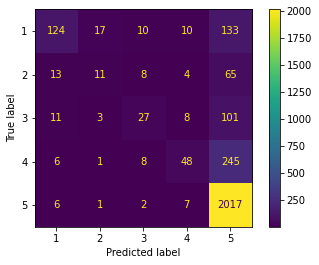

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_model_mn, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

## 4.2 Decision Tree

Fit and predict for TFIDF

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_dict = {
    "criterion":["gini", "entropy"],
    "max_depth":range(1,10),
    "min_samples_split":range(2,10),
    "min_samples_leaf":range(1,5)
}

dtree = GridSearchCV(DecisionTreeClassifier(), param_dict, verbose=1, cv=3, scoring="f1_micro")

dtree.fit(X_train, y_train)
preds_train = dtree.predict(X_test)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


Fit and predict for TFIDF + Ngram

In [18]:
dtree = GridSearchCV(DecisionTreeClassifier(), param_dict, verbose=1, cv=3, scoring="f1_micro")

dtree.fit(X_train_2, y_train_2)
preds_train_2 = dtree.predict(X_test_2)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


Fit and predict for TFIDF + Ngram + Pos tagging

In [19]:
dtree = GridSearchCV(DecisionTreeClassifier(), param_dict, verbose=1, cv=3, scoring="f1_micro")

dtree.fit(X_train_3, y_train_3)
preds_train_3 = dtree.predict(X_test_3)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


Confusion matrix of TFIDF

In [20]:
from sklearn.metrics import classification_report
print("Metrics \n" 
      +classification_report(y_true=y_test, y_pred=preds_train))

# Confussion Matrix
print("Confussion Matrix:\n")
matriz = pd.crosstab(y_test, preds_train, rownames=['actual'], colnames=['preds'])
print(matriz)

Metrics 
              precision    recall  f1-score   support

           1       0.60      0.05      0.09       294
           2       0.00      0.00      0.00       101
           3       0.38      0.02      0.04       150
           4       0.17      0.00      0.01       308
           5       0.71      0.99      0.83      2033

    accuracy                           0.71      2886
   macro avg       0.37      0.21      0.19      2886
weighted avg       0.60      0.71      0.59      2886

Confussion Matrix:

preds    1  2  3  4     5
actual                   
1       15  0  2  0   277
2        0  0  0  0   101
3        0  0  3  0   147
4        2  0  0  1   305
5        8  1  3  5  2016


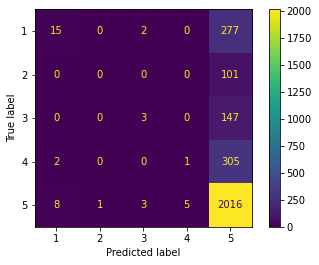

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, preds_train, labels=dtree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtree.classes_)
disp.plot()

Comparing results

In [22]:
from sklearn.metrics import f1_score

grid_pred_acc = f1_score(y_test, preds_train, average='micro')
grid_pred_acc_2 = f1_score(y_test_2, preds_train_2, average='micro')
grid_pred_acc_3 = f1_score(y_test_3, preds_train_3, average='micro')

print(f"Prediciton using Decision Tree + GridSearchCV (with cross validation)")
print(f" - TFIDF: {grid_pred_acc}")
print(f" - TFIDF + Ngram: {grid_pred_acc_2}")
print(f" - TFIDF + Ngram + POS tagging: {grid_pred_acc_3}")


Prediciton using Decision Tree + GridSearchCV (with cross validation)
 - TFIDF: 0.7051282051282052
 - TFIDF + Ngram: 0.7141372141372141
 - TFIDF + Ngram + POS tagging: 0.702009702009702
